In [1]:
%matplotlib notebook
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
from pprint import pprint

Let's import the SED fitting code which use `prospector` package.

In [2]:
from pyprosp import prospector

# Data

For this tutorial, we will fit the SED based on some photometric measurements.<br>
What's important with input data is the names you give:

- measurements must be on the format "instrument.band" (e.g. sdss.u, ps1.g, ...)
- uncertainties must be on the format "instrument.band.err" (e.g. sdss.u.err, ps1.g.err, ...)

The measurement uncertainties are necessary for the code to automatically recognize the filters used.<br>
Here we set a `pandas.Series` with data, as it could come from a `pandas.DataFrame` in a loop, but it also works with a dictionary.

These data are coming from "Johnson et al. 2013", the studied galaxy is "NGC4163", measured in maggies.

In [3]:
data = {"SN_name":"NGC4163",
        "zcmb":0.000551,
        "GALEX.FUV":5.91561634e-08, 
        "GALEX.FUV.err":5.91561634e-09, 
        "GALEX.NUV":8.87156012e-08, 
        "GALEX.NUV.err":8.87156012e-09, 
        "sdss.u":2.22843515e-07,
        "sdss.u.err":2.22843515e-08,
        "sdss.g":4.87528490e-07,
        "sdss.g.err":4.87528490e-08,
        "sdss.r":6.98232404e-07,
        "sdss.r.err":6.98232404e-08,
        "sdss.i":8.79022517e-07,
        "sdss.i.err":8.79022517e-08,
        "sdss.z":9.46237161e-07,
        "sdss.z.err":9.46237161e-08, 
        "Spitzer.irac_1":4.32513831e-07, 
        "Spitzer.irac_1.err":4.32513831e-08, 
        "Spitzer.irac_2":2.80543364e-07, 
        "Spitzer.irac_2.err":2.80543364e-08, 
        "Spitzer.irac_3":1.95884467e-07, 
        "Spitzer.irac_3.err":1.95884467e-08, 
        "Spitzer.irac_4":1.29419584e-07, 
        "Spitzer.irac_4.err":1.29419584e-08, 
        }

data = pandas.Series(data)
data

SN_name                   NGC4163
zcmb                     0.000551
GALEX.FUV             5.91562e-08
GALEX.FUV.err         5.91562e-09
GALEX.NUV             8.87156e-08
GALEX.NUV.err         8.87156e-09
sdss.u                2.22844e-07
sdss.u.err            2.22844e-08
sdss.g                4.87528e-07
sdss.g.err            4.87528e-08
sdss.r                6.98232e-07
sdss.r.err            6.98232e-08
sdss.i                8.79023e-07
sdss.i.err            8.79023e-08
sdss.z                9.46237e-07
sdss.z.err            9.46237e-08
Spitzer.irac_1        4.32514e-07
Spitzer.irac_1.err    4.32514e-08
Spitzer.irac_2        2.80543e-07
Spitzer.irac_2.err    2.80543e-08
Spitzer.irac_3        1.95884e-07
Spitzer.irac_3.err    1.95884e-08
Spitzer.irac_4         1.2942e-07
Spitzer.irac_4.err     1.2942e-08
dtype: object

# Prospector SED fitting

## Initialization

Now that we have data to work with, let's build a `prospector` object.

In [4]:
prosp = prospector.Prospector()

Prospector can work either with measured photometry or spectrum (or with both).<br>
Here we give the data we constructed above (`phot=data`). Note that no matter there are some additional informations in these data, the code ignore them, only photometry is managed (with the constraints on name format highlighted above).<br>
We let `spec` to None (`spec=None`, default value).
We inform the code of the measurement unit (`unit="mgy"`). Note that there are other available units treated by the code:
- "Hz": erg/s/cm2/Hz
- "AA": erg/s/cm2/AA
- "mgy": maggies
- "Jy": Jansky
- "mag": magnitudes

This unit defines the your measurements in general, whether you give photometry or spectrometry. However if you give both, you cannot define a different unit for each one. They must be in the same unit.

The builder also accept a redshift value to fix it in the SED fitting. If `z` is set to None, the redshift becomes a free parameter for the fit.<br>
Finally, you can optionally give an object name.

In [5]:
prosp.set_data(phot=data, spec=None, unit="mgy", z=data.zcmb, name=data.SN_name)

# Can be executed directly in the builder:
# prosp = prospector.Prospector(phot=data, spec=None, unit="mgy", z=data.zcmb, name=data.SN_name)

`prospector` needs now three specific objects to be built: 
- the `obs` containing every measurements
- the `model` synthesizing the parameters defining the SED model. The free paramters of the model will be fitted during SED fitting.
- the `sps` refering to the Stellar Population Synthesis, calling FSPS procedures.

It doesn't matter in which order you build `obs` and `model`, but `sps` has to be built after the `model` (because it depends on the paramters implemented in the `model`).

### Build `obs`

Firstly, let's build the `obs` object, which basically is a dictionary formatted to be used in `prospector`.

In this example, we are working with photometry. We may want to avoid some filter measurements during the SED fitting. This can be done by giving a list of filters to be used for the fit to `phot_mask` argument (there is an example in next cell in comment). Filters must be on the format "instrument.band" (e.g. sdss.u, ps1.g, ...).

A few options allow to print some user messages:
- `verbose`: print the built `obs` dictionary (default is False)
- `warning`: print warning messages if there's any, noticing some anomalies but without breaking the code

In addition of this example, if you are working on spectroscopy, you can also apply a mask on the measured spectrum by giving limits to `spec_mask` argument in Angstroms (a few examples below).

Finally, if you already have an `obs` prospector compatible dictionary, you can give it in `obs` argument. In this case, `set_data` allow you to choose if you want to save the data from this dictionary in your instance's attributes.

In [6]:
# Example of photometric mask (running SED fitting only on SDSS filters):
# phot_mask = ["sdss.u", "sdss.g", "sdss.r", "sdss.i", "sdss.z"]

# Examples of spectroscopic masks:
# spec_mask = None ; (None, None) ; (1000, None) ; (1e3, 1e5) ; ...

prosp.build_obs(phot_mask=None, verbose=True, warnings=True)#, spec_mask=(None, None), obs=None, set_data=False)


#===============#
#   Built obs   #
#===============#

{'filternames': ['galex_FUV',
                 'galex_NUV',
                 'sdss_u0',
                 'sdss_g0',
                 'sdss_r0',
                 'sdss_i0',
                 'sdss_z0',
                 'spitzer_irac_ch1',
                 'spitzer_irac_ch2',
                 'spitzer_irac_ch3',
                 'spitzer_irac_ch4'],
 'filters': [<class 'sedpy.observate.Filter'>(galex_FUV),
             <class 'sedpy.observate.Filter'>(galex_NUV),
             <class 'sedpy.observate.Filter'>(sdss_u0),
             <class 'sedpy.observate.Filter'>(sdss_g0),
             <class 'sedpy.observate.Filter'>(sdss_r0),
             <class 'sedpy.observate.Filter'>(sdss_i0),
             <class 'sedpy.observate.Filter'>(sdss_z0),
             <class 'sedpy.observate.Filter'>(spitzer_irac_ch1),
             <class 'sedpy.observate.Filter'>(spitzer_irac_ch2),
             <class 'sedpy.observate.Filter'>(spitzer_irac_ch3),
    

### Build `model`

This is the trickiest part of the initialization as there are a lot of possibilities highly impacting the SED fitting.

The `model` stores every paramters defining the model which will fit the data.<br>
Before any treatment, the input parameters are dictionaries including some specific keys:
- `name`: the parameter's name
- `N`: parameter's length (vector parameters are possible)
- `init`: the initial value
- `isfree`: a boolean defining the parameter to free (for SED fitting) or fixed to the `init` value

If the parameter is free (`isfree=True`), you finally need to define:
- `prior`: the prior probability to apply to the parameter during SED fitting

There are a few other optionnal parameters, like:
- `units`: unit of the parameter
- `init_disp`: the initial dispersion to use when generating clouds of emcee "walkers"
- `disp_floor`: the minimum dispersion to use when generating clouds of emcee "walkers".


Here is an example (creating a model with only a "stellar mass" like parameter):

In [7]:
model_tuto = {"mass_tuto":{"N": 1,
                           "isfree": True,
                           "init": 1e8,
                           "prior": dict(name="LogUniform", mini=1e6, maxi=1e12),
                           "init_disp": 1e6, 
                           "disp_floor": 1e6, 
                           "units": "solar masses formed"}, 
              # ... : {...}, 
              }

# Could also be: 
# model_tuto = [{"name":"mass_tuto", 
#                "N": 1,
#                "isfree": True,
#                "init": 1e8,
#                "prior": dict(name="LogUniform", mini=1e6, maxi=1e12),
#                "init_disp": 1e6, 
#                "disp_floor": 1e6, 
#                "units": "solar masses formed"}, 
#               {...}, 
#              ]

About priors, the code will automatically build an appropriate prior instance based on a dictionary containing every needed arguments.

In the parameter `mass_tuto`, `prior = dict(name="LogUniform", mini=1e6, maxi=1e12)`. You can get more informations from this stuff with:

In [8]:
# prosp.describe_priors("LogUniform")
prosp.describe_priors(dict(name="LogUniform", mini=1e6, maxi=1e12))

# If you want to print every avalaible prior informations, run: 
# prosp.describe_priors("*")


#========================#
#   Prior descriptions   #
#========================#

Available priors: TopHat, Normal, ClippedNormal, LogNormal, LogUniform, Beta, StudentT, SkewNormal.

(Required arguments must be included in addition with the 'name' argument in a dictionary to correctly build the prior, 
 for example, try to describe 'priors={'name':'Normal', 'mean':0., 'sigma':1.}').


+----------------+
|   LogUniform   |
+----------------+

Like log-normal, but the distribution of natural log of the variable is
    distributed uniformly instead of normally.

    - mini: (your input is: 1000000.0)
        Minimum of the distribution

    - maxi: (your input is: 1000000000000.0)
        Maximum of the distribution
    


However, instead of building a model from scratch by hand, `prospector` propose a set of pre-packaged parameter sets.

You can have a look at them with:

In [9]:
# You can have a full description of every templates with:
# prosp.describe_templates("*")

# We will limit the print length with the description of the two templates we'll use:
prosp.describe_templates(["parametric_sfh", "dust_emission", "nebular"])


#=========================#
#   Availbale templates   #
#=========================#

'type_defaults':
  Explicitly sets dust amd IMF types.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'dust_emission':
  The set of (fixed) dust emission parameters.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'nebular_marginalization':
  Marginalize over emission amplitudes line contained inthe observed spectrum
'fit_eline_redshift':
  Fit for the redshift of the emission lines separatelyfrom the stellar redshift
'outlier_model':
  The set of outlier (mixture) models for spectroscopy and photometry
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'igm':
  The set of (fixed) IGM absorption parameters.
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a pol

With all these elements, let's now build the `model`.<br>
Once again, the instance method `build_model` includes a few arguments.
- `model`: if you created your own model you can add it here (with our example, we add `model_tuto` and see below how to remove it)
- `templates`: here you can give one or a list of template names to build the model. be careful of the order of the names in the list, because the code is using `dict.update` function in the order of the list.
- `describe`: print the description of the priors from the given model (if any) and the given templates (if any).
- `verbose`: print the built `model`

The code starts to build the model with the given one, and then update it with the given templates (if any). If no initial model is given (thus only templates), it starts from the first given template, and then update it with the following ones.

In [10]:
prosp.build_model(model=model_tuto, templates=["parametric_sfh", "dust_emission", "nebular"], 
                  describe=False, verbose=True)


#=================#
#   Built model   #
#=================#

{'add_dust_emission': {'N': 1, 'init': True, 'isfree': False},
 'add_neb_continuum': {'N': 1, 'init': True, 'isfree': False},
 'add_neb_emission': {'N': 1, 'init': True, 'isfree': False},
 'dust2': {'N': 1,
           'init': 0.6,
           'isfree': True,
           'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0),
           'units': 'optical depth at 5500AA'},
 'dust_type': {'N': 1, 'init': 0, 'isfree': False},
 'duste_gamma': {'N': 1,
                 'init': 0.001,
                 'isfree': False,
                 'prior': <class 'prospect.models.priors.LogUniform'>(mini=0.001,maxi=0.15),
                 'units': 'Mass fraction of dust in high radiation intensity.'},
 'duste_qpah': {'N': 1,
                'init': 4.0,
                'isfree': False,
                'prior': <class 'prospect.models.priors.TopHat'>(mini=0.5,maxi=7.0),
                'units': 'Percent mass fraction of PAHs in dust.

Once the model is built, we can still modify it, using `modify_model`.

In this example, we built the model from a handly made one with a tutorial parameter `mass_tuto`. In practical, templates already include a well defined stellar mass parameter (in some of the templates, it even depends on other parameters...). Thus, here, we want to remove `mass_tuto` from the model. We can do that giving a list of parameters to remove from the model to the `removings` argument.

*Note: One could say that we could run again the previous cell without giving `model_tuto`to `model` argument. Indeed, but we want here to show the possiblities of the code...*

Additionaly, depending on the object we are studying, we may want to change the prior probability for some of the parameters, or the initial value, etc. This can be done giving a dictionary very similar to the model creation (see `model_tuto` creation), but only containing parameters with new values. Then, the code applies the changes giving this dictionary to the `changes` argument.

*Note: Two important things coming with the `changes` argument: if there is one (or more) parameter in the given dictionary not existing yet in the model, the code add it to the model ; if there is one (or more) key in one parameter of the given dictionary not existing yet in the same parameter from the model, the code add it to the model.*

The code apply changes before the removings...

Here again, a few more arguments:
- `describe`: print the description of the priors from the given changes (if any).
- `verbose`: print the previous `model` and the final modified one.
- `warnings`: print warning messages if there's any, noticing some anomalies but without breaking the code

In [11]:
changes = {"dust2":{"init":0.05}, 
           "tage":{"init":13., "disp_floor":1.},
           "mass":{"init":1e8, "prior":{"name":"LogUniform", "mini":1e6, "maxi":1e10}, 
                   "init_disp": 1e6, "disp_floor":1e6},
           "tau":{"prior":{"name":"LogUniform", "mini":1e-1, "maxi":1e2}, "disp_floor":1.}, 
           }

removings = ["mass_tuto", "not_existing_parameter"]
# Note that we add in the list of removings a parameter which doesn't exist in the model, 
# but the code just inform you that it already doesn't exist by a warning 
# (which can even be not printed if 'warnings = False').

prosp.modify_model(changes=changes, removings=removings, verbose=True, warnings=True, describe=False)


#====================#
#   Previous model   #
#====================#

{'add_dust_emission': {'N': 1,
                       'init': True,
                       'isfree': False,
                       'name': 'add_dust_emission'},
 'add_neb_continuum': {'N': 1,
                       'init': True,
                       'isfree': False,
                       'name': 'add_neb_continuum'},
 'add_neb_emission': {'N': 1,
                      'init': True,
                      'isfree': False,
                      'name': 'add_neb_emission'},
 'dust2': {'N': 1,
           'init': 0.6,
           'isfree': True,
           'name': 'dust2',
           'prior': <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0),
           'units': 'optical depth at 5500AA'},
 'dust_type': {'N': 1, 'init': 0, 'isfree': False, 'name': 'dust_type'},
 'duste_gamma': {'N': 1,
                 'init': 0.001,
                 'isfree': False,
                 'name': 'duste_gamma',
                 'pri

/Users/mart1/anaconda3/lib/python3.7/site-packages/pyprosp-0.2.2-py3.7.egg/pyprosp/prospector.py:416: UserWarning: 'disp_floor' is not included in 'tage' model parameters. Adding it...
/Users/mart1/anaconda3/lib/python3.7/site-packages/pyprosp-0.2.2-py3.7.egg/pyprosp/prospector.py:416: UserWarning: 'init_disp' is not included in 'mass' model parameters. Adding it...
/Users/mart1/anaconda3/lib/python3.7/site-packages/pyprosp-0.2.2-py3.7.egg/pyprosp/prospector.py:416: UserWarning: 'disp_floor' is not included in 'mass' model parameters. Adding it...
/Users/mart1/anaconda3/lib/python3.7/site-packages/pyprosp-0.2.2-py3.7.egg/pyprosp/prospector.py:416: UserWarning: 'disp_floor' is not included in 'tau' model parameters. Adding it...
/Users/mart1/anaconda3/lib/python3.7/site-packages/pyprosp-0.2.2-py3.7.egg/pyprosp/prospector.py:456: UserWarning: Cannot remove 'not_existing_parameter' as it doesn't exist in the current model.


That's all for the `model`.

### Build `sps`

Last step of the `prospector` initialization is to build the `sps`. As we said above, to be automatically built, `build_sps` has to be executed after `build_model`, because the `sps` depends on the `model` parameters.

This method accepts two arguments:
- `sps`: if you already have a built `sps`, you can give it here.
- `zcontinuous`: this is a `python-fsps` parameter controlling how metallicity interpolation of the SSPs is acheived (a value of 1 is recommended):
    - 0: use discrete indices (controlled by parameter "zmet")
    - 1: linearly interpolate in log Z/Z_\sun to the target metallicity (the parameter "logzsol")
    - 2: convolve with a metallicity distribution function at each age (the MDF is controlled by the parameter "pmetals")

*Note: this can take a bit of time the first time you build it, but will be much faster as long as you don't restart the kernel.*

In [12]:
prosp.build_sps(zcontinuous=1)

The `prospector` initialization is now done. Let's run the SED fitting.

## SED fitting

### `dynesty`

`prospector` proposes different way to fit the SED: a basic minimization, the MCMC sampling using `emcee` and a dynamic nested sampling using `dynesty`. In this tutorial, we only show how to use `dynesty` and `emcee`.

Each one has its own running parameters, which can be described with `describe_run_parameters` method.

Let's begin with `dynesty` (`prospector` doesn't contain a lot of comments of these parameters, but you can have a look at the given website):

In [13]:
prosp.describe_run_parameters("dynesty")


#====================================#
#   Running parameters description   #
#====================================#


+-------------+
|   dynesty   |
+-------------+

    nested_bound: (optional, default: 'multi')

    nested_sample: (optional, default: 'unif')

    nested_nlive_init: (optional, default: 100)

    nested_nlive_batch: (optional, default: 100)

    nested_dlogz_init: (optional, default: 0.02)

    nested_maxcall: (optional, default: None)

    nested_walks: (optional, default: 25)

    
    There are more informations on these parameters at:
        https://dynesty.readthedocs.io/en/latest/api.html#dynesty.dynesty.DynamicNestedSampler



Here are some example convenient values to give to dynesty (look at `run_params` dictionary, below).

You can run the SED fitting using `run_fit` method.<br>
It accepts a few arguments:
- `which`: choice of SED fitter (here we'll start with "dynesty")
- `run_params`: running parameters (should be a kwargs dictionary compatible with the chosen SED fitter)
- `savefile`: allow to write a .h5 file with the fit results (this can be done with a separate method, see below)
- `set_chains`: allow to build the parameter chains coming from the SED fitting with default values (can also be done with a seperate method controlling arguments)
- `verbose`: print some time informations

In [14]:
run_params = {"nested_method":"rwalk", 
              "nlive_init":400, 
              "nlive_batch":200, 
              "nested_dlogz_init":0.05, 
              "nested_posterior_thresh":0.05, 
              "nested_maxcall":int(1e7)}

prosp.run_fit(which="dynesty", run_params=run_params, savefile=None, set_chains=False, verbose=True)

iter: 2148 | batch: 0 | nc: 1 | ncall: 8422 | eff(%): 25.505 | logz: 160.692 +/-  0.540 | dlogz:  0.000 >  0.050           


done dynesty (initial) in 605.4958930015564s


iter: 5064 | batch: 7 | nc: 4 | ncall: 18910 | eff(%): 25.893 | loglstar: 171.115 < 177.706 < 176.672 | logz: 160.811 +/-  0.526 | stop:  1.010     

done dynesty (dynamic) in 363.1007013320923s
Done 'dynesty' in 969s.


In [15]:
pprint(prosp.fit_output)

{'optimization': (None, 0.0),
 'sampling': ({'batch_bounds': array([[        -inf,          inf],
       [173.77065643, 175.62560174],
       [172.99542412, 173.77075924],
       [172.62419314, 173.00872403],
       [172.16050345, 176.3818622 ],
       [171.75862923, 172.16399074],
       [171.39225125, 176.25344288],
       [171.11481746, 176.67163251]]),
               'batch_nlive': array([100, 100, 100, 100, 100, 100, 100, 100]),
               'eff': 25.892963094814288,
               'information': array([-8.27263149e+09, -3.97969371e+08,  8.88053008e+07, ...,
        1.43527904e+01,  1.43534176e+01,  1.43540868e+01]),
               'logl': array([-2.53679404e+13, -2.81535488e+12, -2.04817917e+12, ...,
        1.77976842e+02,  1.78041891e+02,  1.78064350e+02]),
               'logvol': array([-9.95033085e-03, -1.99006617e-02, -2.98509926e-02, ...,
       -2.41397210e+01, -2.45451861e+01, -2.52383333e+01]),
               'logwt': array([-2.53679404e+13, -2.81535488e+12, -2.04817

The SED fitting is now done and stored in `fit_output` attribute.

You can build and store the parameter chains using `set_chains`. This method accepts two arguments:
- `data`: chains coming from SED fitting. Note that `emcee` (multiple walkers) and `dynesty` (one walker) give different chains format, but the code handle that point. This argument accept data coming from the SED fitting output itself, or chains saved in a .h5 file. If None is given, it automatically takes the fit output data.
- `start`: set the step from which the chains are stored. You can give an integer, applied on every walkers (the one from `dynesty` or every walkers from `emcee`). If you give None, the default value depends on the fitter choice (`emcee` takes 0, `dynesty` takes a convenient value when the dynamic sampling start to stabilize).

Let's run it with the default values (note that it's similar to run `run_fit` with the argument `set_chains=True`, see above).

In [16]:
prosp.set_chains(data=None, start=None)

Finally, we can write SED fitting results in a .h5 file with the method `write_h5`. It's basically using the `prospector` writing codes, to which we add a save of the model and the sps instances to load them quickly.

To run it we just have to give file name or directory, ending with ".h5" (note that it's equivalent to directly give the file name to `savefile` argument of `run_fit` method).

*Note: If the file already exists, it will raise an exception (which actually is strange because `prospector` package is supposed to add a timestamp to the file name in this case...). However, if you tried to save the results directly from the `run_fit` method and unfortunately get this exception, don't worry, you don't have to run again the SED fitting! The results are stored as an attribute of the instance and you can still save them with `write_h5`.*

In [17]:
prosp.write_h5(savefile="tutorial_dynesty.h5")

/Users/mart1/anaconda3/lib/python3.7/site-packages/prospect-0.4.0-py3.7.egg/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
/Users/mart1/anaconda3/lib/python3.7/site-packages/prospect-0.4.0-py3.7.egg/prospect/io/write_results.py:278: RuntimeWarning: Could not JSON serialize model_params, pickled instead


### `emcee`

Let's now use `emcee`. Once again, we can start visualizing what the availble running parameters are (much more exhaustive than for `dynesty`).

In [18]:
prosp.describe_run_parameters("emcee")


#====================================#
#   Running parameters description   #
#====================================#


+-----------+
|   emcee   |
+-----------+

    initial_positions: (optional, default: None)
        If given, a set of initial positions for the emcee walkers.  Must have
        shape (nwalkers, ndim).  Rounds of burn-in will be skipped if this
        parameter is present.

    Extra Parameters
    --------

    nwalkers:
        The number of walkers to use.  If None, use the nearest power of two to
        ``ndim * walker_factor``.

    niter:
        Number of iterations for the production run

    nburn:
        List of the number of iterations to run in each round of burn-in (for
        removing stuck walkers.) E.g. `nburn=[32, 64]` will run the sampler for
        32 iterations before reinitializing and then run the sampler for
        another 64 iterations before starting the production run.

    storechain: (default: True)
        If using HDF5 output, sett

Here again an example of some convenient values for this tutorial is given (see below the `run_params` dictionary).

Now that we know how the seperate methods work, we will use the shortcuts with `run_fit` arguments:
- `which`: choice of SED fitter (here we'll start with "dynesty")
- `run_params`: running parameters (should be a kwargs dictionary compatible with the chosen SED fitter)
- `savefile`: allow to write a .h5 file with the fit results (here we directly give the file name, shortcuting the seperate method `write_h5`)
- `set_chains`: allow to build the parameter chains coming from the SED fitting with default values (here we set `True`, doing it right after the fit and shorcuting the method of the same name)
- `verbose`: print some time informations

In [19]:
run_params = {"nwalkers":16, 
              "niter":1024, 
              "nburn":[128, 256, 512]}

prosp.run_fit(which="emcee", run_params=run_params, savefile="tutorial_emcee.h5", set_chains=True, verbose=True)

number of walkers=16


/Users/mart1/anaconda3/lib/python3.7/site-packages/prospect-0.4.0-py3.7.egg/prospect/models/priors.py:104: RuntimeWarning: divide by zero encountered in log


done burn #0 (128 iterations)
done burn #1 (256 iterations)
done burn #2 (512 iterations)
number of walkers=16
starting production
done production
Done 'emcee' in 896s.


In [20]:
pprint(prosp.fit_output)

{'optimization': (None, 0.0),
 'sampling': (<emcee.ensemble.EnsembleSampler object at 0x7ff14167ded0>,
              896.1323871612549)}


And here we are, the SED fitting has been done with two different methods using `prospector` package processes. Fit outputs have been saved in files and we can now work with them.

*Note: everything that we will do from now on can be done directly on the present instance. However, we will show how to start from a previously made SED fitting.*

# Working with SED fitting results

*Note: you can execute the following cells without running what's above, except for the importings and at the condition that you did the SED fitting once to create the saving files.*

## Openning files

`pyprosp` allows the user to build an instance directly from a .h5 file using `from_h5`. This method takes as argument: 
- `filename`: the file name or directory (ending with ".h5")
- `warnings`: print warning messages if there's any, noticing some anomalies but without breaking the code

Let's do this with the files we made earlier:

In [21]:
h5_choice = "dynesty" 
# Choose here if you want to open the fit results from "dynesty" or "emcee".
# Note that whatever your choice is, every following methods should work fine.

In [22]:
prosp_h5 = prospector.Prospector.from_h5(f"tutorial_{h5_choice}.h5", warnings=True)

From this object, you have access to everything we did from the beginning of this notebook.

Let's now visualize the results.

## Plotting the fit results

`prospector` package includes some plotting functions really useful. For example here is a way to plot the fitted parameter chains:

<IPython.core.display.Javascript object>


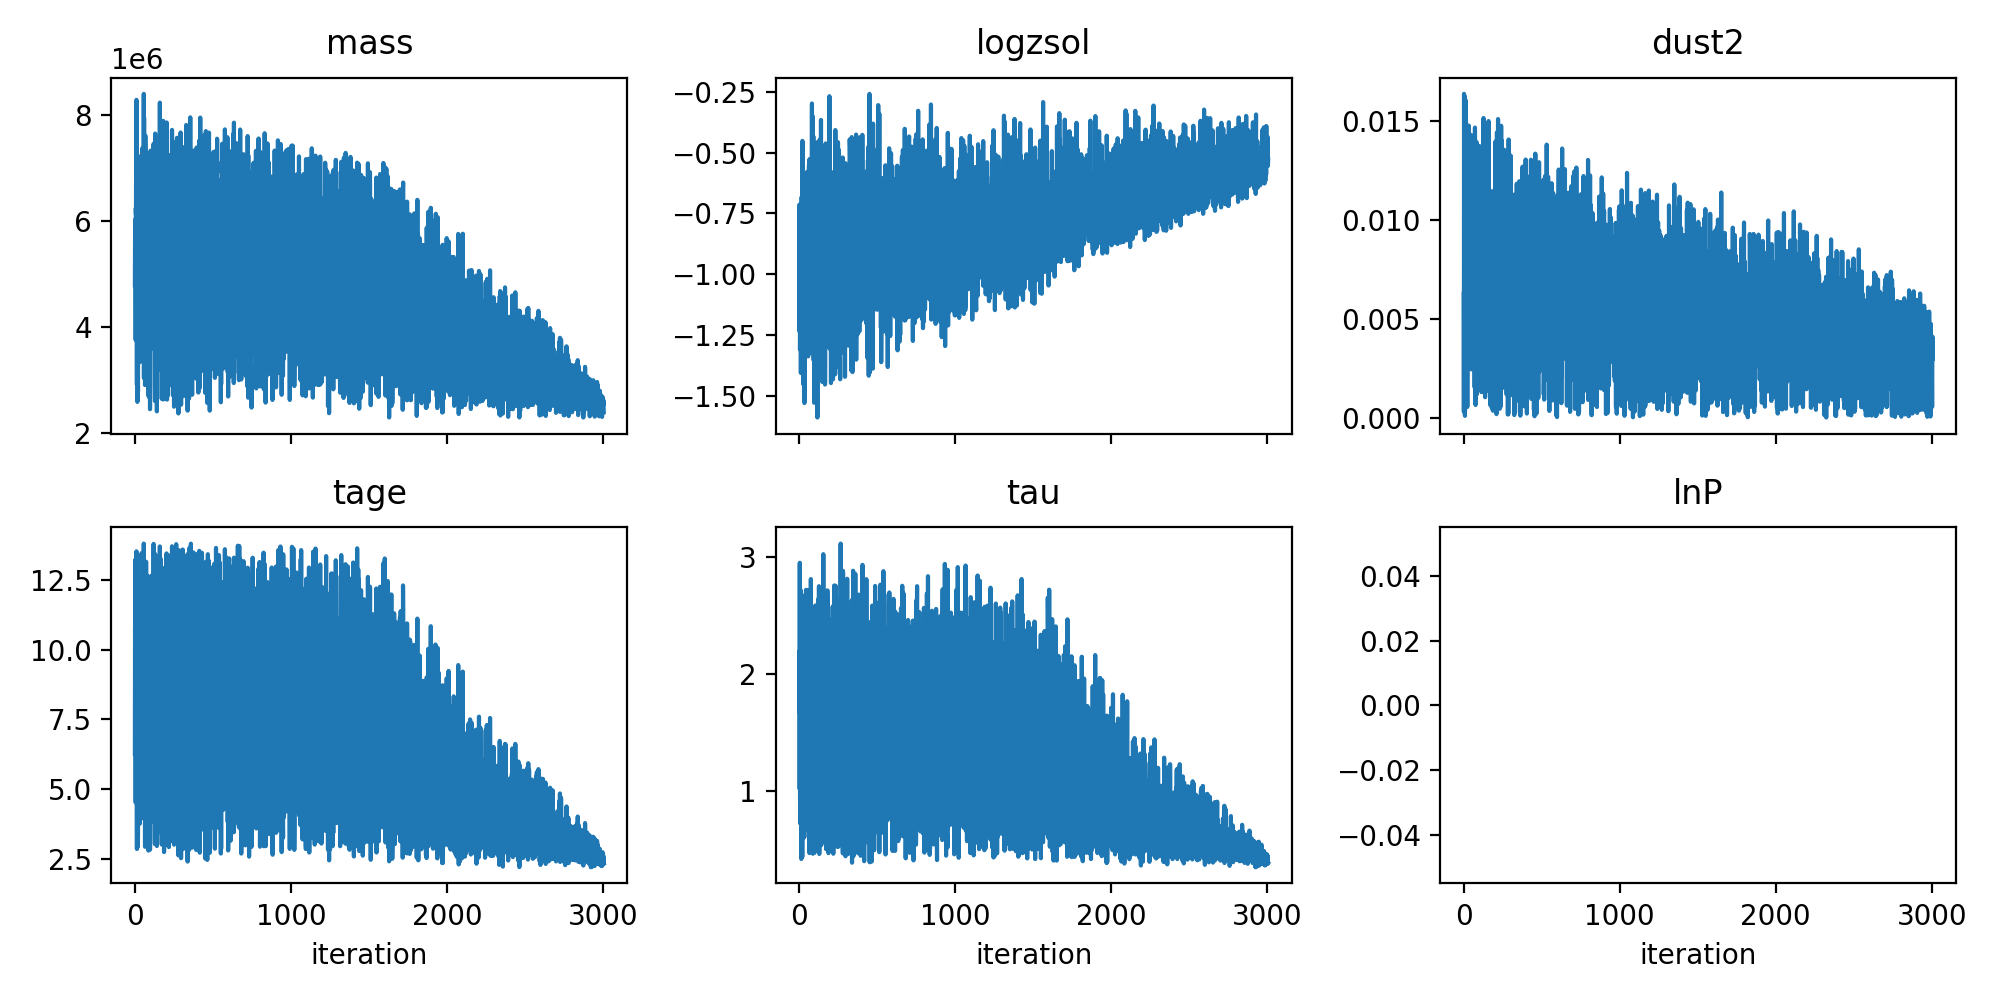

In [23]:
_ = prosp_h5.show_walkers(savefile=None, figsize=(10,5))

# You can have a look at extra arguments taping 'tab' in the parenthese

This method returns the matplotlib.figure.Figure.<br>
If you want to save it, you can give a file name or directory to the argument `savefile`.

Another useful plot is the corner (same remarks as just above):

<IPython.core.display.Javascript object>


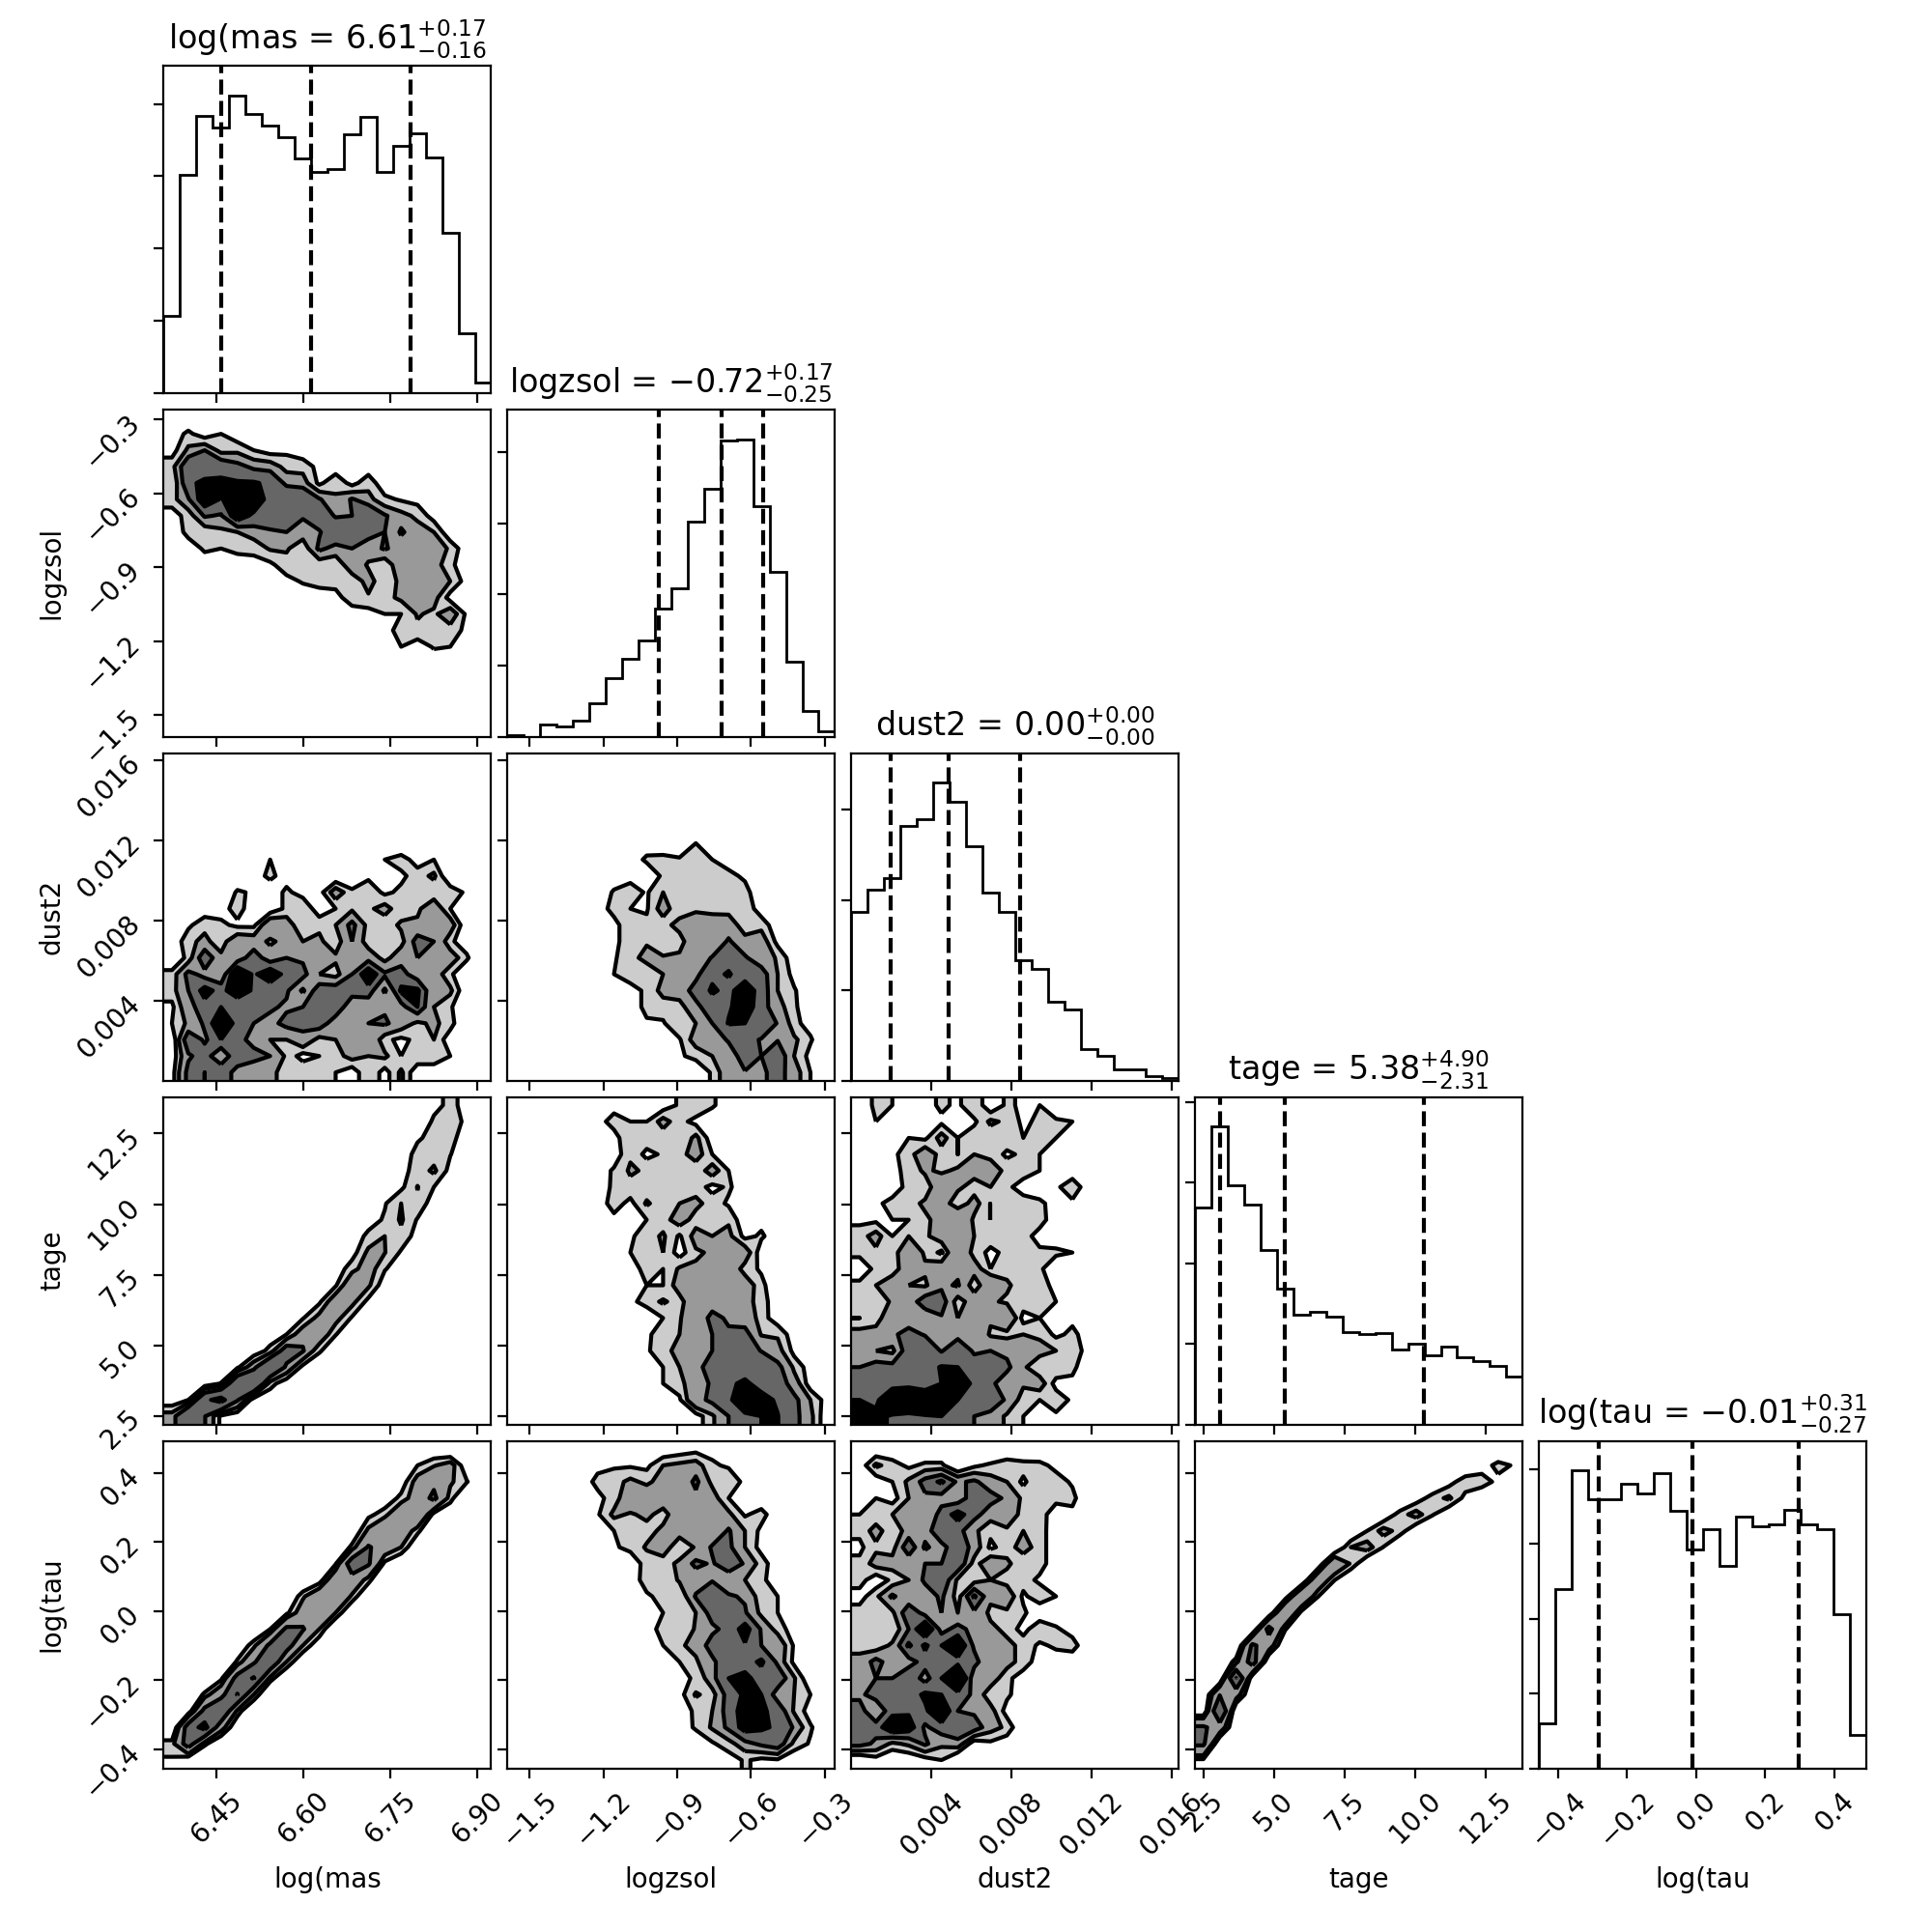

In [24]:
_ = prosp_h5.show_corner(fig=plt.subplots(5,5,figsize=(10,10))[0])

# Here again, you can have a look at extra arguments taping 'tab' in the parenthese

## Posteriors

Finally, let's have a look at parameter posteriors:

In [25]:
prosp_h5.fitted_params

{'mass': (4111534.641527579, 1240603.0229125386, 1982246.9714657124),
 'logzsol': (-0.7198518224893304, 0.25368542825492757, 0.17089789833804925),
 'dust2': (0.004878259125516097, 0.0028882395938991715, 0.0035436035746650666),
 'tage': (5.382870206864338, 2.314429372971617, 4.90103044278527),
 'tau': (0.9748592843503888, 0.45156599321350377, 1.0029255376707695)}

In this dictionary, for each fitted parameter of the model is given a tuple containing the chain's median, one sigma down, one sigma up. The calculation is made recovering 16%, 50% and 84% of the chain.

## Spectrum

In [26]:
from pyprosp import spectrum

Let's now extract the resulting spectrum. There are two ways of doing so:
- you can recover it as an attibute of the present instance
- you can buiild it from a .h5 file (just like above reading file to build a `Prospector` instance)

What's important to notice is that we will work on a `ProspectorSpectrum` instance:

In [27]:
# Either recover the spectrum with:
# prosp_spec = prosp_h5.spectrum

# or with:
prosp_spec = spectrum.ProspectorSpectrum.from_h5(f"tutorial_{h5_choice}.h5", warnings=True)

Next step is to extract spectra from the parameter chains. We do this with the `load_spectra` method, taking as arguments:
- `from_file`: if you already extracted the spectra and saved them in file, you load them giving the file name here
- `size`: allow to control the size of the spectrum chain. If you give an integer, the code take that many sets of fitted parameters to build the spectrum chain. Giving `None` means that the full chains are used. Can help to reduce the calculation time.
- `savefile`: allow to save the spectrum chain in a file giving its name or directory (see more details below)
- `warnings`: print warning messages if there's any, noticing some anomalies but without breaking the code

This can take time, depending on the length of the fitted parameter chains.

In [28]:
prosp_spec.load_spectra(from_file=None, size=None, savefile=None, warnings=True)

Now that the spectrum chain is extracted, it may be useful to write it in a file (to earn time reloading it, or for other personal purposes...). The method `load_spectra` can directly do it with its argument `savefile`. But here are a few more details.

The method `write_spec` can execute two different process:
- if you give a file name ending with ".h5", it creates in the given file a group and add as attribute each step of the spectrum chain and the corresponding wavelength array. Note that you can give the SED fitting results file to add the spectrum chain inside.
- in other cases, the code will try to run `pandas.DataFrame.to_csv()` function (note that `write_spec` can take as extra arguments the ones from `to_csv`).

In [29]:
prosp_spec.write_spec(savefile=f"tutorial_{h5_choice}.h5")

**Important:**<br>
Let's notice here an important point. Remember that we can load a `ProspectorSpectrum` instance directly from a .h5 file (see above). If the given file contains the spectrum chain, the code automatically load it in the instance (so that you don't have to run `load_spectra` feeding the `from_file` argument with the file).

Let's have a quick look at the spectrum chain:

In [30]:
prosp_spec.spec_chain

,0,1,2,3,4,5,6,7,8,9,...,2997,2998,2999,3000,3001,3002,3003,3004,3005,3006
lbda,,,,,,,,,,,,,,,,,,,,,
9.105014e+01,1.707736e-13,1.884439e-13,1.555418e-13,1.848171e-13,1.491850e-13,1.997297e-13,1.695726e-13,1.992778e-13,2.153173e-13,2.532674e-13,...,2.726342e-13,2.490055e-13,2.693865e-13,2.587313e-13,2.491292e-13,2.710470e-13,2.204669e-13,2.677326e-13,2.679014e-13,2.722853e-13
9.405179e+01,1.762945e-13,1.931624e-13,1.614206e-13,1.900174e-13,1.551249e-13,2.084656e-13,1.751113e-13,2.050658e-13,2.209049e-13,2.592953e-13,...,2.835675e-13,2.584166e-13,2.803667e-13,2.693005e-13,2.585822e-13,2.820463e-13,2.295820e-13,2.786890e-13,2.791037e-13,2.834218e-13
9.605290e+01,2.215400e-13,2.430003e-13,2.031919e-13,2.399136e-13,1.950963e-13,2.612452e-13,2.195302e-13,2.573043e-13,2.775500e-13,3.266330e-13,...,3.556832e-13,3.241742e-13,3.515339e-13,3.378668e-13,3.244113e-13,3.535355e-13,2.879556e-13,3.495577e-13,3.501586e-13,3.555142e-13
9.805400e+01,3.016319e-13,3.291989e-13,2.782345e-13,3.259118e-13,2.675562e-13,3.614314e-13,2.990791e-13,3.497991e-13,3.761592e-13,4.425817e-13,...,4.936489e-13,4.477376e-13,4.884265e-13,4.718321e-13,4.481948e-13,4.911609e-13,4.084487e-13,4.855657e-13,4.871527e-13,4.941502e-13
1.000551e+02,5.336572e-13,4.792035e-13,4.655095e-13,4.480186e-13,4.828913e-13,7.259986e-13,5.030767e-13,5.700256e-13,5.527211e-13,6.015020e-13,...,8.436884e-13,7.785371e-13,8.426118e-13,8.013833e-13,7.756373e-13,8.484365e-13,7.128881e-13,8.367858e-13,8.286697e-13,8.362936e-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.643311e+07,1.230966e-08,1.556760e-08,1.940623e-08,1.889319e-08,1.732061e-08,1.615478e-08,1.665359e-08,1.594799e-08,1.676868e-08,2.041845e-08,...,1.318099e-08,1.274470e-08,1.253248e-08,1.268499e-08,1.264512e-08,1.204443e-08,1.253351e-08,1.286736e-08,1.256699e-08,1.263347e-08
9.732360e+07,1.232653e-08,1.556520e-08,1.943415e-08,1.890222e-08,1.734154e-08,1.617519e-08,1.667545e-08,1.597716e-08,1.680219e-08,2.044738e-08,...,1.316648e-08,1.273550e-08,1.251850e-08,1.268366e-08,1.263831e-08,1.203624e-08,1.254085e-08,1.285288e-08,1.255621e-08,1.262393e-08
9.822409e+07,1.234363e-08,1.558935e-08,1.944852e-08,1.892922e-08,1.735160e-08,1.618534e-08,1.668664e-08,1.599391e-08,1.682207e-08,2.047653e-08,...,1.318677e-08,1.275296e-08,1.253794e-08,1.269739e-08,1.265454e-08,1.205264e-08,1.255079e-08,1.287273e-08,1.257394e-08,1.264134e-08


We are now ready to plot the resulting SED, using the `show` method.<br>
I let you check on the argument descriptions thanks to the docstring. Just know that the values we give in the next cell are the default ones (meaning that `prosp_spec.show()` will give the same plot). We just want to let here an easy access to each one of them to let you modify them as you wish.<br>
It can take a bit of time, depending on the `unit` and the `restframe` choices and on which quantities are plotted, because of the treatment of the whole chains data.<br>
This method returns a dictionary containing the `matplotlib.figure.Figure` (key: `fig`) and the `matplotlib.axes._axes.Axes` (key: `ax`).<br>
Once again, you can save the figure giving a file name or directory to `savefile` argument.

<IPython.core.display.Javascript object>


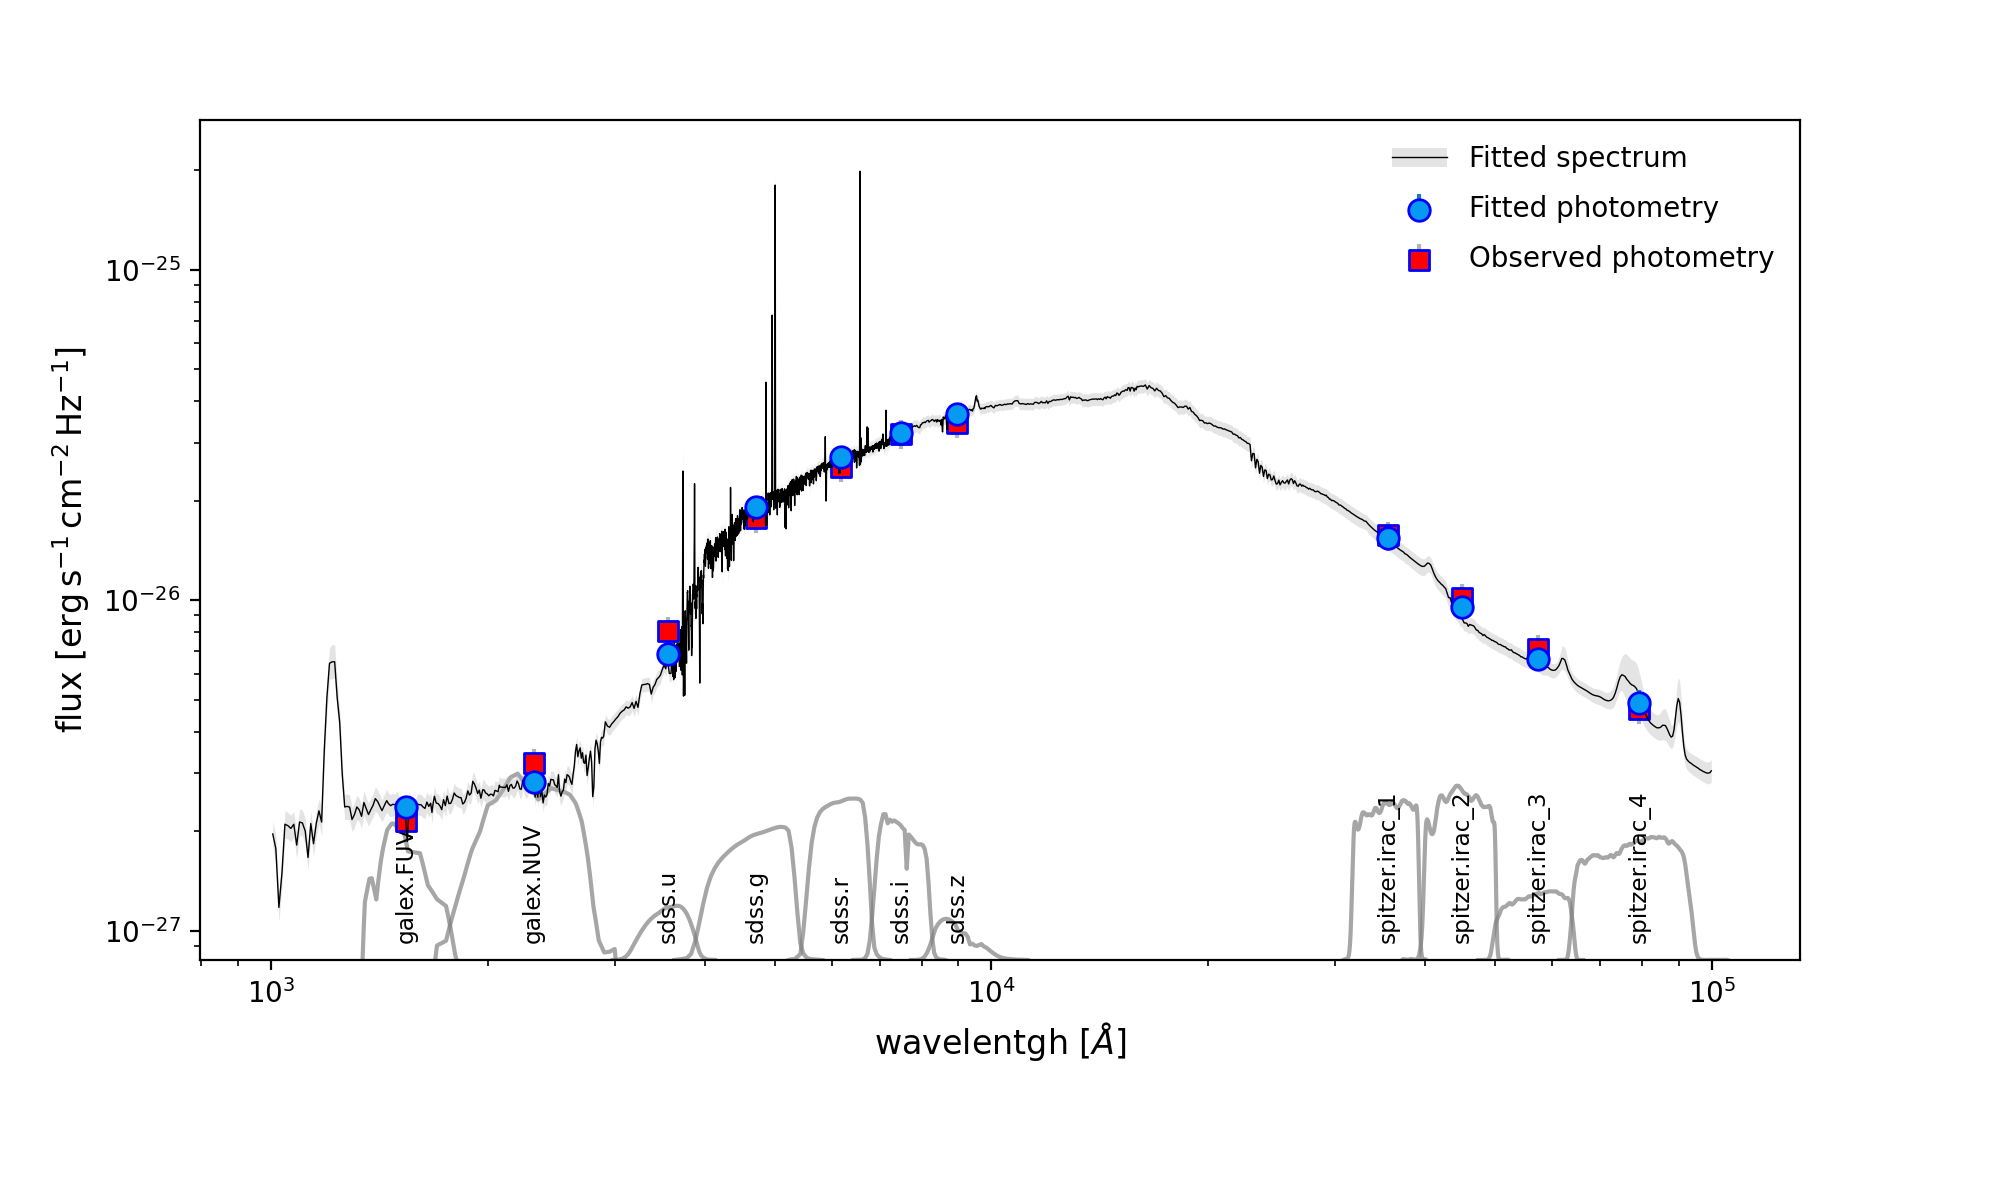

In [31]:
unit = "Hz"
lbda_lim = (1e3, 1e5)
restframe = False
filters = None

ax = None
figsize=(10,6)
ax_rect=[0.1, 0.2, 0.8, 0.7]
set_logx, set_logy = True, True
savefile = None

spec_prop = {"c":"k", "lw":0.5, "zorder":4}
spec_unc_prop = {"color":"0.7", "alpha":0.35, "lw":0, "zorder":2}
phot_prop = {"marker":"o", "s":60, "fc":"xkcd:azure", "ec":"b", "zorder":6}
phot_unc_prop = {"marker":"", "ls":"None", "ecolor":"C0", "zorder":5}
obs_phot_prop = {"marker":"s", "s":50, "ls":"None", "facecolors":"r", "edgecolors":"b", "zorder":4}
obs_phot_unc_prop = {"marker":"", "ls":"None", "ecolor":"0.7", "zorder":3}
show_legend = {"loc":"best", "frameon":False, "labelspacing":0.8}
show_filters = {"lw":1.5, "color":"gray", "alpha":0.7, "zorder":1}

fig, ax = prosp_spec.show(ax=ax, figsize=figsize, ax_rect=ax_rect, unit=unit, restframe=restframe, 
                          lbda_lim=lbda_lim, spec_prop=spec_prop, spec_unc_prop=spec_unc_prop, 
                          filters=filters, phot_prop=phot_prop, phot_unc_prop=phot_unc_prop, 
                          obs_spec_prop=obs_spec_prop, obs_spec_unc_prop=obs_spec_unc_prop, 
                          obs_phot_prop=obs_phot_prop, obs_phot_unc_prop=obs_phot_unc_prop, 
                          show_legend=show_legend, set_logx=set_logx, set_logy=set_logy, 
                          show_filters=show_filters, savefile=savefile).values()

## K-corrected photometry

`pyprosp` has a basic process to get the restframed SED and extract photometry from it, which allow the user to get k-corrected photometry.

We can recover photometric data from the SED thanks to the `get_phot_data` method. It accepts as arguments:
- `filters`: list of filter choices for which to get photometric data (check docstring for specific inputs, like `None` in the the next cell, giving the photometry for every filters given by the user as in the very beginning of this notebook)
- `restframe`: choose here if you want to restframe the SED (`True`) or not (`False`) before the photometry extracting, defining if it will be k-corrected or not resp.
- `exp`: exposant for the redshift flux dilution applied on SED in erg/s/cm2/AA (meaning that the SED flux is multiplied by $(1 + z)^{\textrm{exp}}$)
- `unit`: unit of the returned photometry
- `plot_format`: option on the returned dictionary format (set `False` for a user friendly format)

*Note: there is a similar function to get spectral data --> `get_spectral_data`.*

In [32]:
phot_data = prosp_spec.get_phot_data(filters=None, restframe=True, exp=3, unit="mag", plot_format=False)
pprint(phot_data)

{'galex.FUV': {'lbda': 1537.7737130805479,
               'phot': (17.96323684778011,
                        0.07916300365030793,
                        0.08179410896382322),
               'phot_chain': array([18.27066454, 17.97720373, 17.96535037, ..., 17.97734295,
       17.98372289, 17.97435324])},
 'galex.NUV': {'lbda': 2314.387876616991,
               'phot': (17.778504113532833,
                        0.06728936139214525,
                        0.06738325558685432),
               'phot_chain': array([18.00197124, 17.88659144, 17.76071132, ..., 17.72048326,
       17.71989113, 17.71743654])},
 'sdss.g': {'lbda': 4716.237683423511,
            'phot': (15.6950353821361,
                     0.05422976043558769,
                     0.05853322395415361),
            'phot_chain': array([15.7119181 , 15.85031071, 15.70045719, ..., 15.64660357,
       15.65098102, 15.6587247 ])},
 'sdss.i': {'lbda': 7496.361852493177,
            'phot': (15.135334761823037,
                   

## Physical parameters

In [33]:
from pyprosp import phys_params

Finally, let's extract the resulting physical parameters. Once again, there are two ways of doing so:
- you can recover it as an attibute of the present instance
- you can buiild it from a .h5 file (just like above reading file to build a `Prospector` instance)

We will work on a `ProspectorPhysParams` instance:

In [34]:
# Either recover the spectrum with:
# prosp_phys_params = prosp_h5.phys_params

# or with:
prosp_phys_params = phys_params.ProspectorPhysParams.from_h5(f"tutorial_{h5_choice}.h5", warnings=True)

Let's have a look at all available physical parameters.

In [35]:
prosp_phys_params.describe_phys_params()


#=====================================#
#   Physical parameters description   #
#=====================================#

You can get physical parameter values running 'get_phys_params' method on a loaded instance.
You can either give as argument one or a list of the following keys, or "*" to get all of them.
(Note that you'll finally only get the available ones depending on the SED fitted model)


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

You can easily get the above available physical parameters running `get_phys_params`. As it is said above, you can either give as argument one or a list of keys, or "\*" ("all" also works) to get all of them. The method returns a dictionary containing, for each desired parameter, a tuple with the chain median, one sigma bellow it and one sigma above.

*Note: the physical parameters are "availble" if the fitted model does include the needed parameters to extract them.*

A few optionnal arguments:
- `reset`: if `True`, empty the stored physical parameters (if any) before to extract the desired ones. Else, simply update/add them.
- `warnings`: print warning messages if there's any, noticing some anomalies but without breaking the code

In [36]:
prosp_phys_params.get_phys_params(params="*", reset=False, warnings=True)

/Users/mart1/anaconda3/lib/python3.7/site-packages/pyprosp-0.2.2-py3.7.egg/pyprosp/phys_params.py:410: UserWarning: You tried to set the physical parameter 'dust1' for which it raised the error:
<class 'KeyError'> --> "'dust_ratio' is not in the model.".
/Users/mart1/anaconda3/lib/python3.7/site-packages/pyprosp-0.2.2-py3.7.egg/pyprosp/phys_params.py:410: UserWarning: You tried to set the physical parameter 'tburst' for which it raised the error:
<class 'KeyError'> --> "'fage_burst' is not in the model.".


{'z': (0.000551, 0.0, 0.0),
 'mass': (4111534.641527579, 1240603.0229125386, 1982246.9714657124),
 'log_mass': (6.614003953736829, 0.1559811054464726, 0.17088293222709883),
 'sfr': (9.382780284173903e-05, 1.14036708721566e-05, 1.1872870814339038e-05),
 'log_sfr': (-4.02766845339482, 0.05627716494740298, 0.05174620793932405),
 'ssfr': (2.2957607064131777e-11,
  7.978348276910514e-12,
  1.013023972565323e-11),
 'log_ssfr': (-10.639073381648743, 0.18543629452639188, 0.15874188767901032),
 'log_zsol': (-0.7198518224893304, 0.25368542825492757, 0.17089789833804925),
 'tage': (5.382870206864338, 2.314429372971617, 4.90103044278527),
 'tau': (0.9748592843503888, 0.45156599321350377, 1.0029255376707695),
 'dust2': (0.004878259125516097, 0.0028882395938991715, 0.0035436035746650666),
 'duste_gamma': (0.001, 0.0, 0.0),
 'duste_qpah': (4.0, 0.0, 0.0),
 'duste_umin': (1.0, 0.0, 0.0),
 'gas_logu': (-2.0, 0.0, 0.0)}

In addition, you can get the physical parameter chains with the attribute `phys_params_chains`.

One last thing is that you can get the corner plot of these physical parameters with `show`.<br>
You can choose which parameters to plot, or let all of them be plotted (just like above, giving "\*" or "all").<br>
As for every previous figures,you can save it giving a file name or directory to `savefile` argument.<br>
In addition, `show` can take every `corner` extra arguments (as for this example where we set the figure size).

<IPython.core.display.Javascript object>


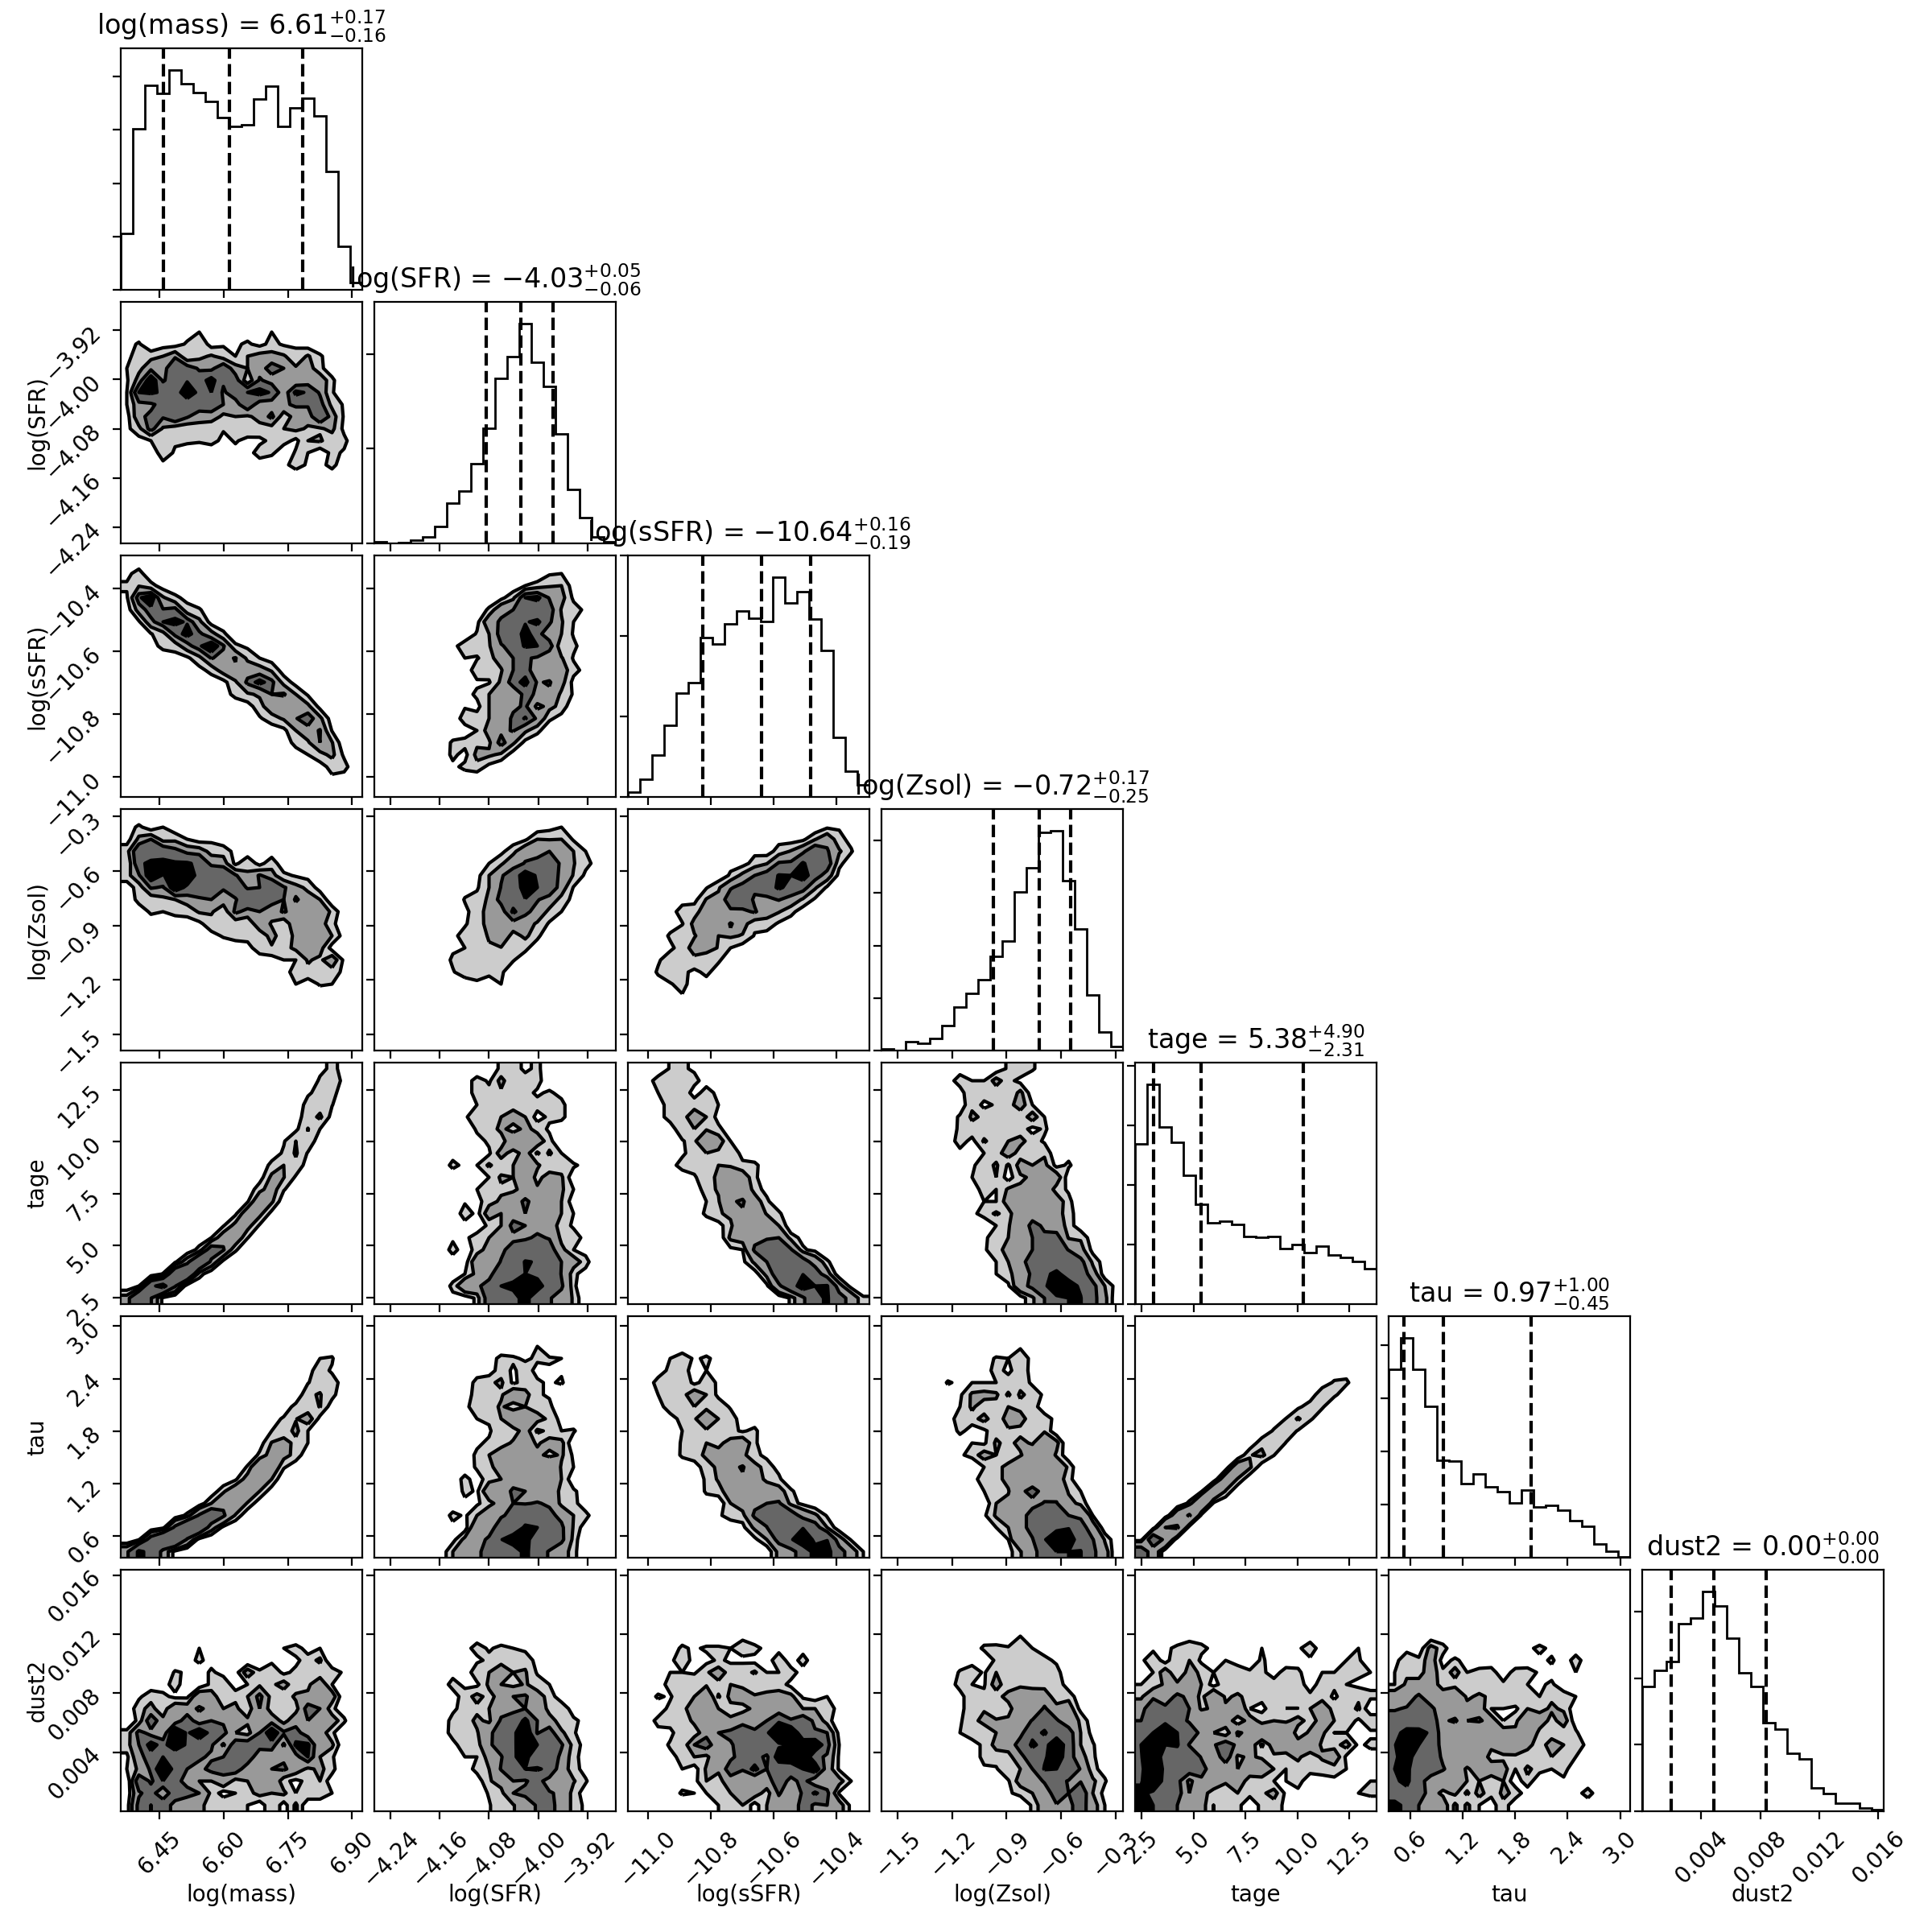

In [37]:
params = ["log_mass", "log_sfr", "log_ssfr", "log_zsol", "tage", "tau", "dust2"]
_ = prosp_phys_params.show(params=params, savefile=None, fig=plt.subplots(7,7,figsize=(12,12))[0])